The Modeling Jupyter Notebook follows an OSEMN process in creating a model that can predict
monthly model auto sales based upon its Consumer Reports features.

# Imports

In [1081]:
# Import necessary packages for project
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from fake_useragent import UserAgent
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Lasso
from statsmodels.formula.api import ols
from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Obtain Data

Read Consumer Reports data to features_df

In [39]:
#Read Consumer Reports data to features_df and reset index
features_df = pd.read_csv('Consumer_Reports.csv', index_col = 0)
features_df.reset_index(inplace=True)
features_df.drop(columns=['index'],inplace=True)

Clean features_df to facilitate merger with monthly sales data

In [43]:
#Create 'Year-Nameplate' to be used as basis for merger with Monthly Sales data
def remove_spaces(value):
    value = value.replace('-','')
    value = value.replace(' ','')
    return value
    
features_df['Nameplate (Cleaned)'] = features_df['Model'].apply(remove_spaces)
features_df['Year-Nameplate'] = features_df.apply(lambda x: str(x['Year'])+x['Nameplate (Cleaned)'], axis=1)

Create function to merge sales data excel files with feature_df

In [219]:
#Create function to read excel files with monthly sales data to df and merge with features_df
def load_sales(excel_file, year, index):
    df = pd.read_excel('./us_monthly_auto_sales/{}'.format(excel_file), header=4)
    df.drop(0, axis=0, inplace=True)
    df = df.loc[:,[df.columns[0],df.columns[index]]]
    df.rename(columns = {'Unnamed: 0': 'Nameplate'}, inplace = True)
    df['Nameplate'] = df['Nameplate'].apply(lambda x: str(x).lower())
    df['Nameplate'] = df['Nameplate'].apply(lambda x: x.replace(' (i)',''))
    df['Nameplate'] = df['Nameplate'].apply(lambda x: x.replace(' (d)',''))
    df['Nameplate'] = df['Nameplate'].apply(lambda x: x.replace('*',''))   
    df['Nameplate (Cleaned)'] = df['Nameplate'].apply(lambda x: x.replace('-',''))
    df['Nameplate (Cleaned)'] = df['Nameplate'].apply(lambda x: x.replace(' ',''))
    df['Year'] = year
    df['Month'] = excel_file.split('-')[0]    
    df['Year-Nameplate'] = df.apply(lambda x: str(x['Year'])+x['Nameplate (Cleaned)'], axis=1)
    merged_df = pd.merge(df, features_df , on = ['Year-Nameplate','Year-Nameplate'])
    merged_df['Sales'] = merged_df.iloc[:,1]
    merged_df.drop(columns = merged_df.iloc[:,1:].columns[0], inplace = True)
    return merged_df

Create sales_df with sales and feature data merged together

In [254]:
#Call load_sales function to merge each month's model sales data with model feature data
#Merge sales_df for all months together to create single sales_df
sales_df = load_sales('12-19-auto-sales.xlsx', 2020, 1)
sales_df = pd.concat([sales_df, load_sales('11-19-auto-sales.xlsx', 2020, 1)])
sales_df = pd.concat([sales_df, load_sales('10-19-auto-sales.xlsx', 2020, 1)])
sales_df = pd.concat([sales_df, load_sales('9-19-auto-sales.xlsx', 2020, 1)])
sales_df = pd.concat([sales_df, load_sales('8-19-auto-sales.xlsx', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('7-19-auto-sales.xlsx', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('6-19-auto-sales.xlsx', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('5-19-auto-sales.xlsx', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('4-19-auto-sales.xlsx', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('3-19-auto-sales.xls', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('2-19-auto-sales.xls', 2019, 1)])
sales_df = pd.concat([sales_df, load_sales('1-19-auto-sales.xls', 2019, 1)])

sales_df = pd.concat([sales_df, load_sales('12-19-auto-sales.xlsx', 2019, 2)])
sales_df = pd.concat([sales_df, load_sales('11-19-auto-sales.xlsx', 2019, 2)])
sales_df = pd.concat([sales_df, load_sales('10-19-auto-sales.xlsx', 2019, 2)])
sales_df = pd.concat([sales_df, load_sales('9-19-auto-sales.xlsx', 2019, 2)])
sales_df = pd.concat([sales_df, load_sales('8-19-auto-sales.xlsx', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('7-19-auto-sales.xlsx', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('6-19-auto-sales.xlsx', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('5-19-auto-sales.xlsx', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('4-19-auto-sales.xlsx', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('3-19-auto-sales.xls', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('2-19-auto-sales.xls', 2018, 2)])
sales_df = pd.concat([sales_df, load_sales('1-19-auto-sales.xls', 2018, 2)])

sales_df = pd.concat([sales_df, load_sales('12-17-auto-sales.xls', 2018, 1)])
sales_df = pd.concat([sales_df, load_sales('11-17-auto-sales.xls', 2018, 1)])
sales_df = pd.concat([sales_df, load_sales('10-17-auto-sales.xls', 2018, 1)])
sales_df = pd.concat([sales_df, load_sales('9-17-auto-sales.xls', 2018, 1)])
sales_df = pd.concat([sales_df, load_sales('8-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('7-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('6-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('5-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('4-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('3-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('2-17-auto-sales.xls', 2017, 1)])
sales_df = pd.concat([sales_df, load_sales('1-17-auto-sales.xls', 2017, 1)])

sales_df = pd.concat([sales_df, load_sales('12-17-auto-sales.xls', 2017, 2)])
sales_df = pd.concat([sales_df, load_sales('11-17-auto-sales.xls', 2017, 2)])
sales_df = pd.concat([sales_df, load_sales('10-17-auto-sales.xls', 2017, 2)])
sales_df = pd.concat([sales_df, load_sales('9-17-auto-sales.xls', 2017, 2)])
sales_df = pd.concat([sales_df, load_sales('8-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('7-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('6-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('5-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('4-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('3-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('2-17-auto-sales.xls', 2016, 2)])
sales_df = pd.concat([sales_df, load_sales('1-17-auto-sales.xls', 2016, 2)])

sales_df = pd.concat([sales_df, load_sales('12-15-auto-sales.xls', 2016, 1)])
sales_df = pd.concat([sales_df, load_sales('11-15-auto-sales.xls', 2016, 1)])
sales_df = pd.concat([sales_df, load_sales('10-15-auto-sales.xls', 2016, 1)])
sales_df = pd.concat([sales_df, load_sales('9-15-auto-sales.xls', 2016, 1)])
sales_df = pd.concat([sales_df, load_sales('8-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('7-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('6-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('5-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('4-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('3-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('2-15-auto-sales.xls', 2015, 1)])
sales_df = pd.concat([sales_df, load_sales('1-15-auto-sales.xls', 2015, 1)])

sales_df = pd.concat([sales_df, load_sales('12-15-auto-sales.xls', 2015, 2)])
sales_df = pd.concat([sales_df, load_sales('11-15-auto-sales.xls', 2015, 2)])
sales_df = pd.concat([sales_df, load_sales('10-15-auto-sales.xls', 2015, 2)])
sales_df = pd.concat([sales_df, load_sales('9-15-auto-sales.xls', 2015, 2)])
sales_df = pd.concat([sales_df, load_sales('8-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('7-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('6-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('5-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('4-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('3-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('2-15-auto-sales.xls', 2014, 2)])
sales_df = pd.concat([sales_df, load_sales('1-15-auto-sales.xls', 2014, 2)])

sales_df = pd.concat([sales_df, load_sales('12-13-auto-sales.xls', 2014, 1)])
sales_df = pd.concat([sales_df, load_sales('11-13-auto-sales.xls', 2014, 1)])
sales_df = pd.concat([sales_df, load_sales('10-13-auto-sales.xls', 2014, 1)])
sales_df = pd.concat([sales_df, load_sales('9-13-auto-sales.xls', 2014, 1)])
sales_df = pd.concat([sales_df, load_sales('8-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('7-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('6-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('5-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('4-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('3-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('2-13-auto-sales.xls', 2013, 1)])
sales_df = pd.concat([sales_df, load_sales('1-13-auto-sales.xls', 2013, 1)])

sales_df = pd.concat([sales_df, load_sales('12-13-auto-sales.xls', 2013, 2)])
sales_df = pd.concat([sales_df, load_sales('11-13-auto-sales.xls', 2013, 2)])
sales_df = pd.concat([sales_df, load_sales('10-13-auto-sales.xls', 2013, 2)])
sales_df = pd.concat([sales_df, load_sales('9-13-auto-sales.xls', 2013, 2)])
sales_df = pd.concat([sales_df, load_sales('8-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('7-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('6-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('5-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('4-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('3-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('2-13-auto-sales.xls', 2012, 2)])
sales_df = pd.concat([sales_df, load_sales('1-13-auto-sales.xls', 2012, 2)])

sales_df = pd.concat([sales_df, load_sales('12-11-auto-sales.xls', 2012, 1)])
sales_df = pd.concat([sales_df, load_sales('11-11-auto-sales.xls', 2012, 1)])
sales_df = pd.concat([sales_df, load_sales('10-11-auto-sales.xls', 2012, 1)])
sales_df = pd.concat([sales_df, load_sales('9-11-auto-sales.xls', 2012, 1)])
sales_df = pd.concat([sales_df, load_sales('8-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('7-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('6-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('5-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('4-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('3-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('2-11-auto-sales.xls', 2011, 1)])
sales_df = pd.concat([sales_df, load_sales('1-11-auto-sales.xls', 2011, 1)])

sales_df = pd.concat([sales_df, load_sales('12-11-auto-sales.xls', 2011, 2)])
sales_df = pd.concat([sales_df, load_sales('11-11-auto-sales.xls', 2011, 2)])
sales_df = pd.concat([sales_df, load_sales('10-11-auto-sales.xls', 2011, 2)])
sales_df = pd.concat([sales_df, load_sales('9-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('8-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('7-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('6-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('5-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('4-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('3-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('2-11-auto-sales.xls', 2010, 2)])
sales_df = pd.concat([sales_df, load_sales('1-11-auto-sales.xls', 2010, 2)])

# Scrub Data

Drop model months with less than 500 units sold

In [551]:
#Drop model months with less than 500 units sold to account for discontinued/incomplete models
data_df = sales_df.loc[sales_df['Sales']>500]

Clean columns with missing values or unmodelable data

In [552]:
#Drop columns with sparse data and duplicative columns
data_df['Month'] = data_df['Month'].astype(int)
data_df.drop(columns = ['Year_x','Overall Score','Road Test Score', 'Warranty', 'Drivetrain Warranty', 
                        'Corrosion Waranty', 'Roadside Aid', 'Free Maintenance', 'Nameplate (Cleaned)_y', 'Fuel Type'],
                         inplace=True)

#Replace Missing values with mean value, minimum value or otherwise based on context
#Map text data into quantitative values
#Update string data types to quantitative data types
data_df = data_df[data_df['Overall Fuel Economy'].notna()]
data_df['Fuel Capacity'] = data_df['Fuel Capacity'].fillna(data_df['Fuel Capacity'].max())
data_df['Towing Capacity'] = data_df['Towing Capacity'].fillna(0)
data_df['Driving Satisfaction'] = data_df['Driving Satisfaction'].fillna(data_df['Driving Satisfaction'].mean())
data_df['Comfort Satisfaction'] = data_df['Comfort Satisfaction'].fillna(data_df['Comfort Satisfaction'].mean())
data_df['Value Satisfaction'] = data_df['Value Satisfaction'].fillna(data_df['Value Satisfaction'].mean())
data_df['Styling Satisfaction'] = data_df['Styling Satisfaction'].fillna(data_df['Styling Satisfaction'].mean())
data_df['Sales'] = data_df['Sales'].astype(int)
data_df['Annual Fuel Cost'] = data_df['Annual Fuel Cost'].apply(lambda x:x.replace(',','').replace('A','200')).astype(int)
reliability_dict = {'N':3, 9:3}
data_df['Reliability Score'] = data_df['Reliability Score'].replace(reliability_dict)
data_df['Reliability Score'] = data_df['Reliability Score'].astype(int)
data_df['Owner Satisfact Score'] = data_df['Owner Satisfact Score'].replace(reliability_dict)
data_df['Owner Satisfact Score'] = data_df['Owner Satisfact Score'].astype(int)
data_df['Headlights'] = data_df['Headlights'].replace(reliability_dict)
data_df['Headlights'] = data_df['Headlights'].astype(int)
seat_dict = {'N':0}
data_df['Rear Seat Score'] = data_df['Rear Seat Score'].replace(reliability_dict)
data_df['Rear Seat Score'] = data_df['Rear Seat Score'].astype(int)
data_df['Third Row Score'] = data_df['Third Row Score'].replace(reliability_dict)
data_df['Third Row Score'] = data_df['Third Row Score'].astype(int)
data_df['Rear Access'] = data_df['Rear Access'].replace(reliability_dict)
data_df['Rear Access'] = data_df['Rear Access'].astype(int)
data_df['Third Access'] = data_df['Third Access'].replace(reliability_dict)
data_df['Third Access'] = data_df['Third Access'].astype(int)
seat_count_dict = {'2 front, 3 rear':5, '2 front, 3 rear, 2 third':7, '2 front, 3 rear, 3 third':8, '2 front, 2 rear':
                  4, '3 front, 3 rear, 3 third': 9, '3 front, 3 rear' : 6, '2 front, 2 rear, 3 third' : 7,
                   '2 front' : 2, '3 front, 2 rear': 5}
data_df['Seats'] = data_df['Seats'].replace(seat_count_dict)
data_df['Seats'] = data_df['Seats'].astype(float)
iihs_dict = {'Good': 4, 'Acceptable' : 3, 'Marginal' : 2, 'Poor' : 1}
data_df['IIHS Moderate Overlap'] = data_df['IIHS Moderate Overlap'].replace(iihs_dict)
data_df['IIHS Moderate Overlap'] = data_df['IIHS Moderate Overlap'].fillna(0)
data_df['IIHS Moderate Overlap'] = data_df['IIHS Moderate Overlap'].astype(int)
data_df['IIHS Driver Overlap'] = data_df['IIHS Driver Overlap'].replace(iihs_dict)
data_df['IIHS Driver Overlap'] = data_df['IIHS Driver Overlap'].fillna(0)
data_df['IIHS Driver Overlap'] = data_df['IIHS Driver Overlap'].astype(int)
data_df['IIHS Passenger Overlap'] = data_df['IIHS Passenger Overlap'].replace(iihs_dict)
data_df['IIHS Passenger Overlap'] = data_df['IIHS Passenger Overlap'].fillna(0)
data_df['IIHS Passenger Overlap'] = data_df['IIHS Passenger Overlap'].astype(int)
data_df['IIHS Side Crash'] = data_df['IIHS Side Crash'].replace(iihs_dict)
data_df['IIHS Side Crash'] = data_df['IIHS Side Crash'].fillna(0)
data_df['IIHS Side Crash'] = data_df['IIHS Side Crash'].astype(int)
data_df['IIHS Rear Crash'] = data_df['IIHS Rear Crash'].replace(iihs_dict)
data_df['IIHS Rear Crash'] = data_df['IIHS Rear Crash'].fillna(0)
data_df['IIHS Rear Crash'] = data_df['IIHS Rear Crash'].astype(int)
data_df['IIHS Roof Crush'] = data_df['IIHS Roof Crush'].replace(iihs_dict)
data_df['IIHS Roof Crush'] = data_df['IIHS Roof Crush'].fillna(0)
data_df['IIHS Roof Crush'] = data_df['IIHS Roof Crush'].astype(int)
safety_dict = {'Optional' : 0, 'Standard' : 1, 'Not offered' : 0, 'Included with stability' : 1, 'Available' : 0}
data_df['Forward Collision Warning'] = data_df['Forward Collision Warning'].replace(safety_dict)
data_df['Forward Collision Warning'] = data_df['Forward Collision Warning'].fillna(0)
data_df['Forward Collision Warning'] = data_df['Forward Collision Warning'].astype(int)
data_df['City Automatic Braking'] = data_df['City Automatic Braking'].replace(safety_dict)
data_df['City Automatic Braking'] = data_df['City Automatic Braking'].fillna(0)
data_df['City Automatic Braking'] = data_df['City Automatic Braking'].astype(int)
data_df['Highway Automatic Braking'] = data_df['Highway Automatic Braking'].replace(safety_dict)
data_df['Highway Automatic Braking'] = data_df['Highway Automatic Braking'].fillna(0)
data_df['Highway Automatic Braking'] = data_df['Highway Automatic Braking'].astype(int)
data_df['Pedestrian Detection'] = data_df['Pedestrian Detection'].replace(safety_dict)
data_df['Pedestrian Detection'] = data_df['Pedestrian Detection'].fillna(0)
data_df['Pedestrian Detection'] = data_df['Pedestrian Detection'].astype(int)
data_df['Lane Departure Warning'] = data_df['Lane Departure Warning'].replace(safety_dict)
data_df['Lane Departure Warning'] = data_df['Lane Departure Warning'].fillna(0)
data_df['Lane Departure Warning'] = data_df['Lane Departure Warning'].astype(int)
data_df['Lane Keep Assist'] = data_df['Lane Keep Assist'].replace(safety_dict)
data_df['Lane Keep Assist'] = data_df['Lane Keep Assist'].fillna(0)
data_df['Lane Keep Assist'] = data_df['Lane Keep Assist'].astype(int)
data_df['Blind Spot Warning'] = data_df['Blind Spot Warning'].replace(safety_dict)
data_df['Blind Spot Warning'] = data_df['Blind Spot Warning'].fillna(0)
data_df['Blind Spot Warning'] = data_df['Blind Spot Warning'].astype(int)
data_df['Rear Traffic Warning'] = data_df['Rear Traffic Warning'].replace(safety_dict)
data_df['Rear Traffic Warning'] = data_df['Rear Traffic Warning'].fillna(0)
data_df['Rear Traffic Warning'] = data_df['Rear Traffic Warning'].astype(int)
data_df['Rear View Camera'] = data_df['Rear View Camera'].replace(safety_dict)
data_df['Rear View Camera'] = data_df['Rear View Camera'].fillna(0)
data_df['Rear View Camera'] = data_df['Rear View Camera'].astype(int)
data_df['Anti Lock Breaks'] = data_df['Anti Lock Breaks'].replace(safety_dict)
data_df['Anti Lock Breaks'] = data_df['Anti Lock Breaks'].fillna(0)
data_df['Anti Lock Breaks'] = data_df['Anti Lock Breaks'].astype(int)
data_df['Traction Control'] = data_df['Traction Control'].replace(safety_dict)
data_df['Traction Control'] = data_df['Traction Control'].fillna(0)
data_df['Traction Control'] = data_df['Traction Control'].astype(int)
data_df['Stability Control'] = data_df['Stability Control'].replace(safety_dict)
data_df['Stability Control'] = data_df['Stability Control'].fillna(0)
data_df['Stability Control'] = data_df['Stability Control'].astype(int)
data_df['Daytime Running Lights'] = data_df['Daytime Running Lights'].replace(safety_dict)
data_df['Daytime Running Lights'] = data_df['Daytime Running Lights'].fillna(0)
data_df['Daytime Running Lights'] = data_df['Daytime Running Lights'].astype(int)
airbag_dict = {'Standard front' : 1, 'Standard front & rear': 1, 'Standard front & optional rear':  1, 
              'Not offered' : 0, 'Optional front' : 0, 'Standard with rollover' : 1, 'Standard': 1, 
               'Optional' : 1}
data_df['Side Airbags'] = data_df['Side Airbags'].replace(airbag_dict)
data_df['Side Airbags'] = data_df['Side Airbags'].fillna(0)
data_df['Side Airbags'] = data_df['Side Airbags'].astype(int)
data_df['Head Airbags'] = data_df['Head Airbags'].replace(airbag_dict)
data_df['Head Airbags'] = data_df['Head Airbags'].fillna(0)
data_df['Head Airbags'] = data_df['Head Airbags'].astype(float)
data_df['Rear Shoulder Room'] = data_df['Rear Shoulder Room'].fillna(0)
data_df['Rear Leg Room'] = data_df['Rear Leg Room'].fillna(0)
data_df['Rear Head Room'] = data_df['Rear Head Room'].fillna(0)
data_df['Third Shoulder Room'] = data_df['Third Shoulder Room'].fillna(0)
data_df['Third Leg Room'] = data_df['Third Leg Room'].fillna(0)
data_df['Third Head Room'] = data_df['Third Head Room'].fillna(0)

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# EDA

Create graph of annual market share by auto brand

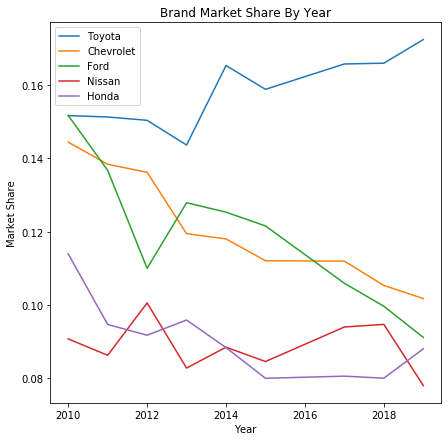

In [1151]:
#Create dfs with annual model sales by brand and market share by brand for top 5 selling brands
total_sales_df = data_df.groupby(['Year_y'])['Sales'].sum()[0:9]
toyota_sales_df = pd.DataFrame(data_df[data_df['Brand'] == 'toyota'].groupby(['Year_y'])['Sales'].sum()[0:9])
toyota_sales_df['Share'] = toyota_sales_df['Sales']/total_sales_df.values
chevrolet_sales_df = pd.DataFrame(data_df[data_df['Brand'] == 'chevrolet'].groupby(['Year_y'])['Sales'].sum()[0:9])
chevrolet_sales_df['Share'] = chevrolet_sales_df['Sales']/total_sales_df.values
ford_sales_df = pd.DataFrame(data_df[data_df['Brand'] == 'ford'].groupby(['Year_y'])['Sales'].sum()[0:9])
ford_sales_df['Share'] = ford_sales_df['Sales']/total_sales_df.values
nissan_sales_df = pd.DataFrame(data_df[data_df['Brand'] == 'nissan'].groupby(['Year_y'])['Sales'].sum()[0:9])
nissan_sales_df['Share'] = nissan_sales_df['Sales']/total_sales_df.values
honda_sales_df = pd.DataFrame(data_df[data_df['Brand'] == 'honda'].groupby(['Year_y'])['Sales'].sum()[0:9])
honda_sales_df['Share'] = honda_sales_df['Sales']/total_sales_df.values

#Graph dfs of annual market share by brand for top 5 brands
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(toyota_sales_df.drop('Sales', axis = 1))
ax.plot(chevrolet_sales_df.drop('Sales', axis = 1))
ax.plot(ford_sales_df.drop('Sales', axis = 1))
ax.plot(nissan_sales_df.drop('Sales', axis = 1))
ax.plot(honda_sales_df.drop('Sales', axis = 1))
ax.set_title('Brand Market Share By Year')
ax.set_xlabel('Year')
ax.set_ylabel('Market Share')
ax.legend(labels=['Toyota','Chevrolet','Ford','Nissan','Honda'], loc = 'upper left')



Create box plot of monthly sales data for all models from 2010-2019

,Sales
count,13217.000000
mean,6990.828705
std,6699.462765
min,501.000000
25%,2208.000000
50%,4629.000000
75%,9413.000000
max,51029.000000


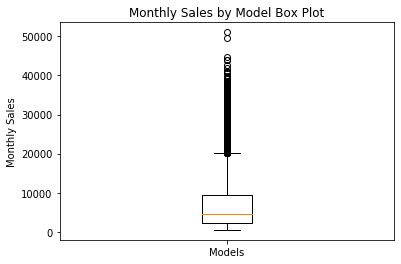

In [978]:
#Create box plot of monthly sales data for all models from 2010-2019
sales_2020_df = data_df['Sales']
fig, ax = plt.subplots()
ax.boxplot(sales_2020_df)
ax.set_xticklabels(labels = ['Models'])
ax.set_ylabel('Monthly Sales')
ax.set_title('Monthly Sales by Model Box Plot')

#Show df of descriptive statistics for montly sales data for all models from 2010-2019
pd.DataFrame(sales_2020_df.describe())

Examine correlation coefficients among indepdent features

In [1163]:
#Create df of correlation coefficients for data df
data_df.corr().iloc[:,0:20].head(50)

,Month,Year_y,Reliability Score,Owner Satisfact Score,Acceleration Score,Zero To Sixty,Transmission Score,Fuel Economy Score,Overall Fuel Economy,City Fuel Economy,Highway Fuel Economy,Annual Fuel Cost,Braking Score,Emergency Handling Score,Ride Score,Noise Score,Front Seat Score,Rear Seat Score,Interior Finish Score,Trunk Score
Month,1.000000,0.087734,-0.005473,0.019740,0.006941,-0.007186,-0.009539,0.012093,0.005395,0.004439,0.006665,-0.008872,0.010949,0.000180,-0.003066,-0.001490,-0.003853,0.008278,-0.002498,-0.000034
Year_y,0.087734,1.000000,0.013797,0.309474,0.056158,-0.132362,-0.097590,0.175357,0.149369,0.138316,0.168046,-0.176283,0.208776,0.011167,0.001460,0.033556,-0.096324,0.013165,-0.053608,0.058606
Reliability Score,-0.005473,0.013797,1.000000,0.287323,-0.029780,0.015701,0.222460,0.088453,0.063332,0.052488,0.058230,-0.089166,-0.047092,-0.018222,-0.006831,0.009341,0.081088,0.029210,-0.036473,-0.026862
Owner Satisfact Score,0.019740,0.309474,0.287323,1.000000,0.295443,-0.347276,0.197686,-0.081035,0.116841,0.132386,0.096800,0.033203,0.010106,-0.080391,0.074500,0.197861,0.193865,0.128865,0.139139,0.232266
Acceleration Score,0.006941,0.056158,-0.029780,0.295443,1.000000,-0.906023,0.197667,-0.365428,-0.095987,-0.051165,-0.115435,0.403554,0.121169,0.053679,0.088871,0.344853,0.416018,-0.019002,0.536081,0.081775
Zero To Sixty,-0.007186,-0.132362,0.015701,-0.347276,-0.906023,1.000000,-0.211458,0.339889,0.074079,0.025255,0.098260,-0.381939,-0.146880,-0.106737,-0.043442,-0.338000,-0.428692,0.036295,-0.554069,-0.076558
Transmission Score,-0.009539,-0.097590,0.222460,0.197686,0.197667,-0.211458,1.000000,-0.013689,0.082726,0.091950,0.069555,0.023331,0.021940,0.063934,0.164663,0.298671,0.353306,0.085089,0.255000,-0.025620
Fuel Economy Score,0.012093,0.175357,0.088453,-0.081035,-0.365428,0.339889,-0.013689,1.000000,0.586349,0.497247,0.668247,-0.904205,0.279434,0.509723,0.124341,-0.207651,-0.140925,-0.213586,-0.267870,-0.286718
Overall Fuel Economy,0.005395,0.149369,0.063332,0.116841,-0.095987,0.074079,0.082726,0.586349,1.000000,0.986025,0.979403,-0.745827,0.086602,0.217380,0.021842,-0.016803,-0.138351,-0.231681,-0.184363,-0.092656
City Fuel Economy,0.004439,0.138316,0.052488,0.132386,-0.051165,0.025255,0.091950,0.497247,0.986025,1.000000,0.937423,-0.674570,0.046840,0.171619,-0.014143,-0.007297,-0.136554,-0.215290,-0.164120,-0.070265


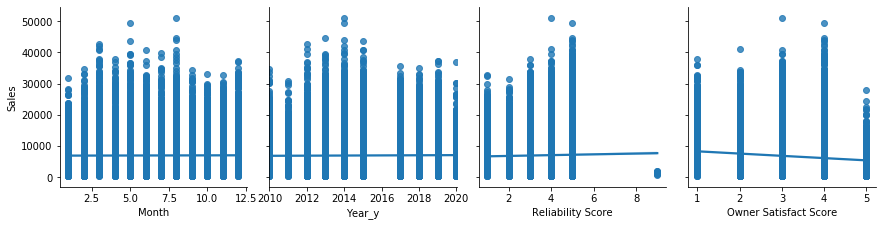

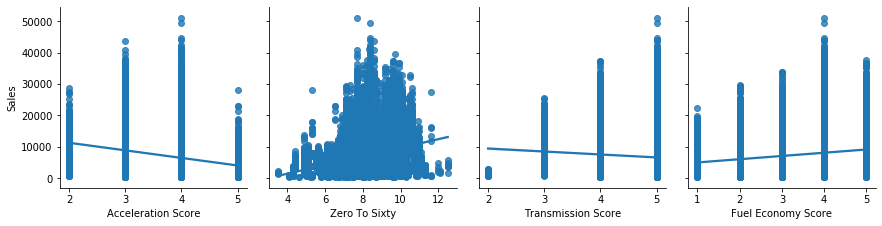

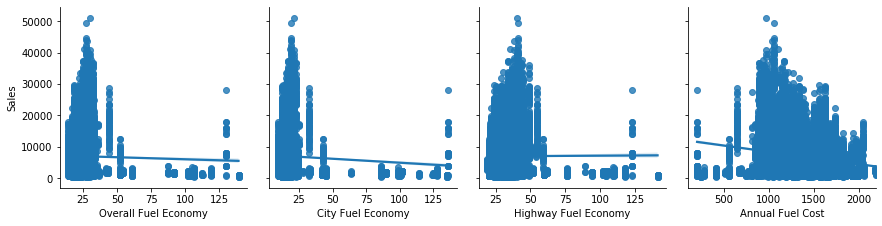

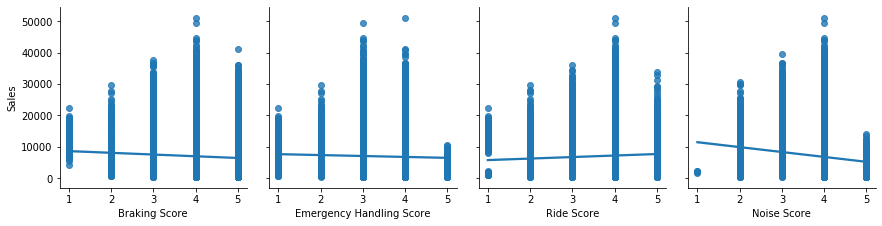

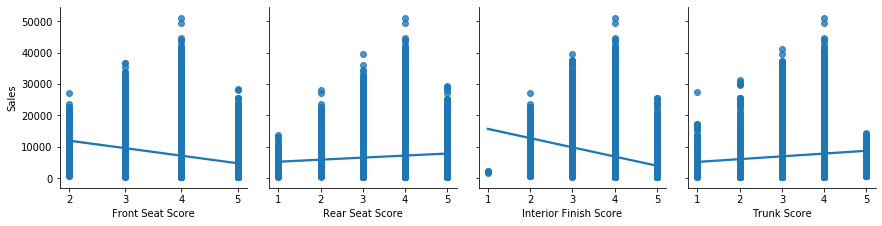

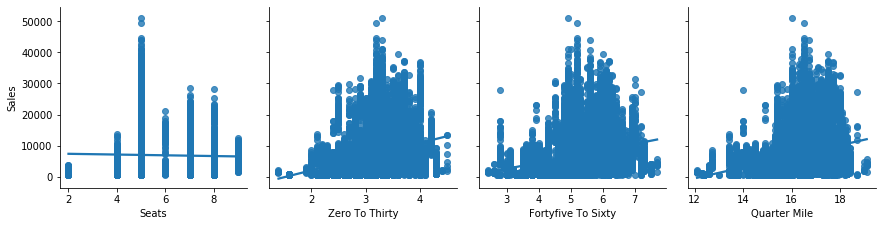

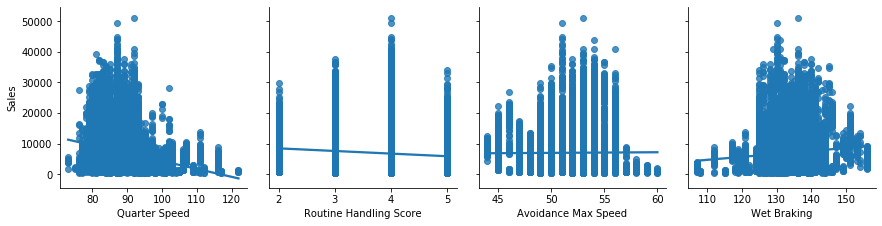

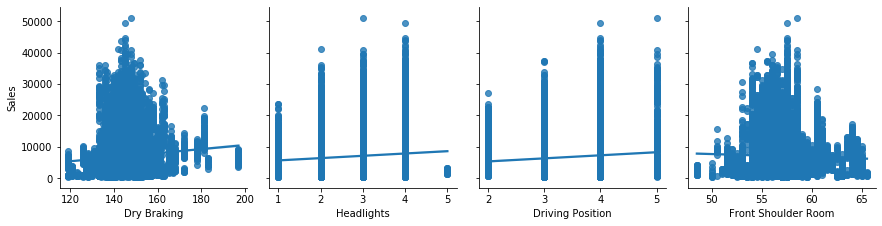

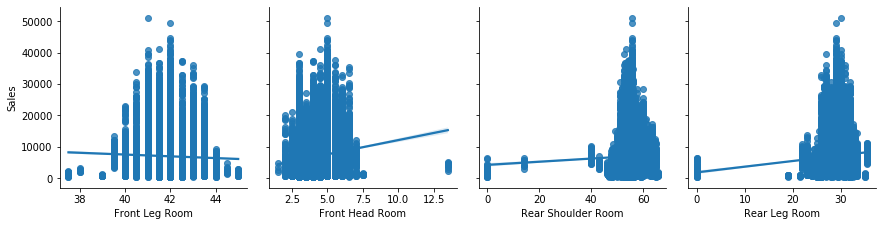

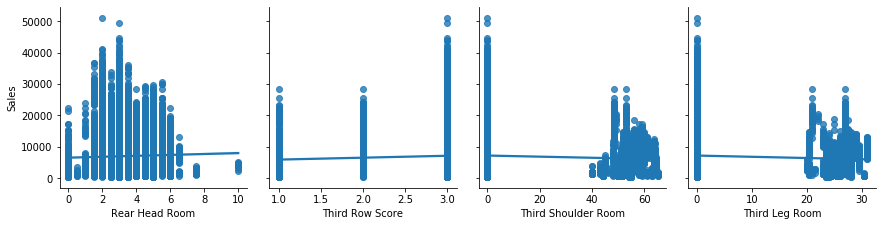

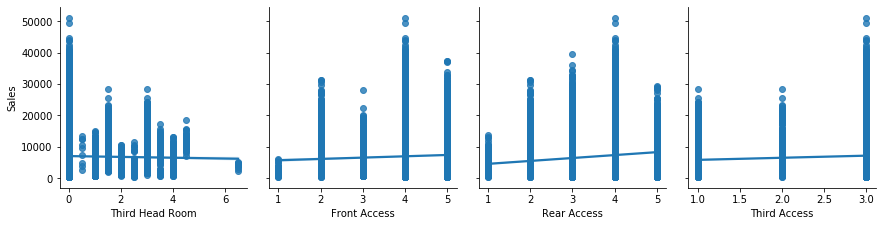

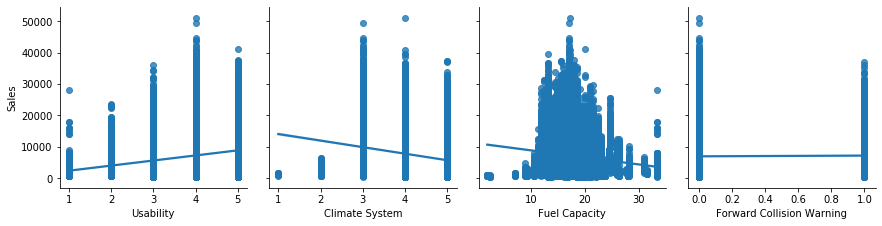

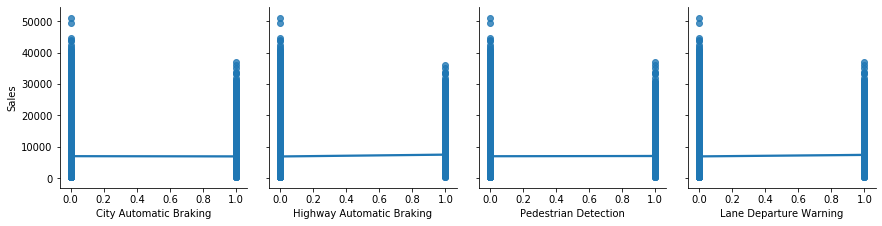

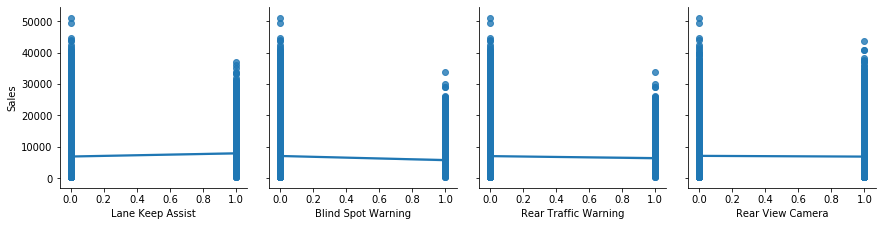

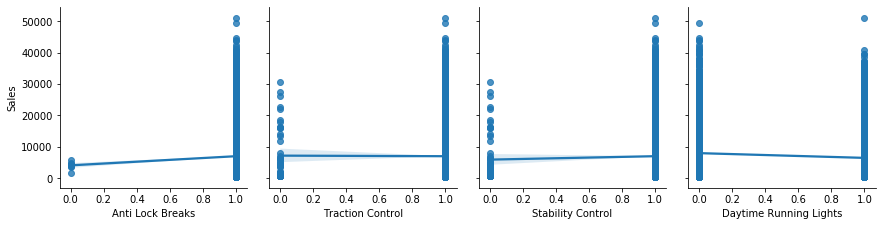

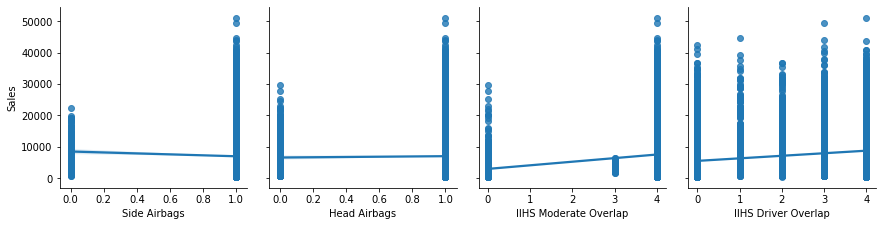

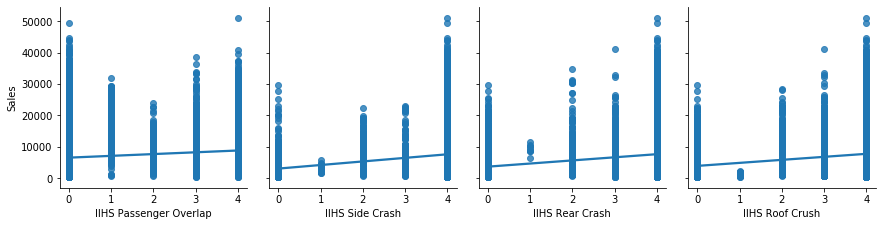

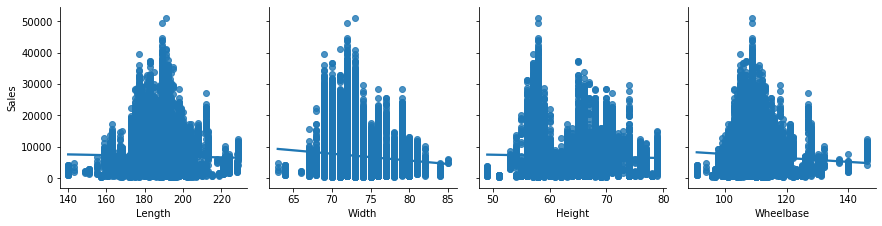

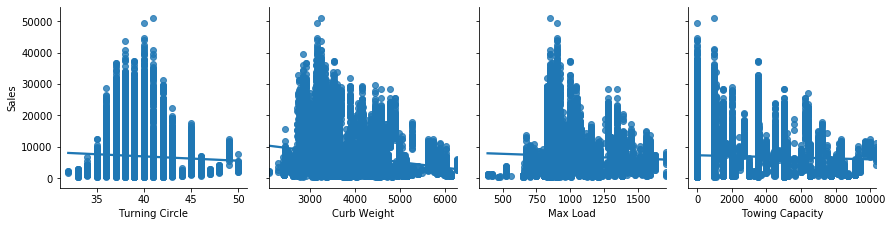

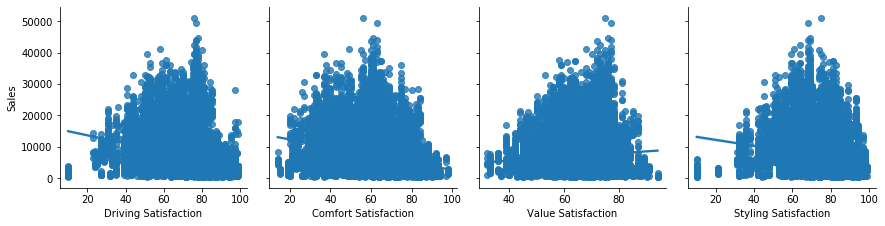

In [1168]:
def pplot_features(df, features,name):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['Sales'], x_vars=row, kind='reg', height=3)
    return pp.savefig(name)

features = ['Month', 'Year_y', 'Reliability Score',
       'Owner Satisfact Score', 'Acceleration Score', 'Zero To Sixty',
       'Transmission Score', 'Fuel Economy Score', 'Overall Fuel Economy',
       'City Fuel Economy', 'Highway Fuel Economy', 'Annual Fuel Cost',
       'Braking Score', 'Emergency Handling Score', 'Ride Score',
       'Noise Score', 'Front Seat Score', 'Rear Seat Score',
       'Interior Finish Score', 'Trunk Score', 'Seats', 'Zero To Thirty',
       'Fortyfive To Sixty', 'Quarter Mile', 'Quarter Speed',
       'Routine Handling Score', 'Avoidance Max Speed', 'Wet Braking',
       'Dry Braking', 'Headlights', 'Driving Position', 'Front Shoulder Room',
       'Front Leg Room', 'Front Head Room', 'Rear Shoulder Room',
       'Rear Leg Room', 'Rear Head Room', 'Third Row Score',
       'Third Shoulder Room', 'Third Leg Room', 'Third Head Room',
       'Front Access', 'Rear Access', 'Third Access', 'Usability',
       'Climate System', 'Fuel Capacity', 'Forward Collision Warning',
       'City Automatic Braking', 'Highway Automatic Braking',
       'Pedestrian Detection', 'Lane Departure Warning', 'Lane Keep Assist',
       'Blind Spot Warning', 'Rear Traffic Warning', 'Rear View Camera',
       'Anti Lock Breaks', 'Traction Control', 'Stability Control',
       'Daytime Running Lights', 'Side Airbags', 'Head Airbags',
       'IIHS Moderate Overlap', 'IIHS Driver Overlap',
       'IIHS Passenger Overlap', 'IIHS Side Crash', 'IIHS Rear Crash',
       'IIHS Roof Crush', 'Length', 'Width', 'Height', 'Wheelbase',
       'Turning Circle', 'Curb Weight', 'Max Load', 'Towing Capacity',
       'Driving Satisfaction', 'Comfort Satisfaction', 'Value Satisfaction',
       'Styling Satisfaction']

pplot_features(data_df, features,'rootcharts')

Text(0.5, 1.08, 'Model Sales by Consumer Reports Overall Score')

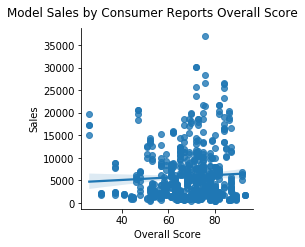

In [756]:
overall_df = sales_df[(sales_df['Year_y'] == 2020)&(sales_df['Sales'] > 500)].loc[:,['Overall Score','Sales']]
overall_df['Sales'] = overall_df['Sales'].astype(int)
ax = sns.pairplot(data=overall_df, y_vars='Sales', x_vars='Overall Score', kind='reg', height=3)
ax.fig.suptitle("Model Sales by Consumer Reports Overall Score", y=1.08)

Text(0.5, 1.08, 'Average Fuel Economy by Model Front Leg Room')

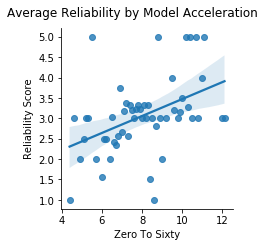

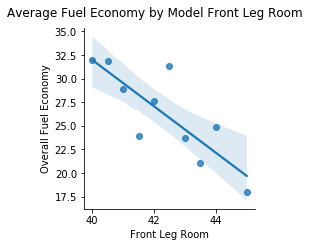

In [757]:
accel_reliability_df = pd.DataFrame(data_df[data_df['Year_y']==2020].groupby('Zero To Sixty')['Reliability Score'].mean())
accel_reliability_df.reset_index(inplace=True)
economy_room_df = pd.DataFrame(data_df[data_df['Year_y']==2020].groupby('Front Leg Room')['Overall Fuel Economy'].mean())
economy_room_df.reset_index(inplace=True)
economy_room_df
ax3 = sns.pairplot(data=accel_reliability_df , y_vars='Reliability Score', x_vars='Zero To Sixty', kind='reg', height=3)
ax3.fig.suptitle("Average Reliability by Model Acceleration", y=1.08)
ax4 = sns.pairplot(data=economy_room_df , y_vars='Overall Fuel Economy', x_vars='Front Leg Room', kind='reg', height=3)
ax4.fig.suptitle("Average Fuel Economy by Model Front Leg Room", y=1.08)


# Modeling

Create x and y variables

In [909]:
columns = ['Month', 'Year_y', 'Reliability Score',
       'Owner Satisfact Score', 'Acceleration Score', 'Zero To Sixty',
       'Transmission Score', 'Fuel Economy Score', 'Overall Fuel Economy',
       'City Fuel Economy', 'Highway Fuel Economy', 'Annual Fuel Cost',
       'Braking Score', 'Emergency Handling Score', 'Ride Score',
       'Noise Score', 'Front Seat Score', 'Rear Seat Score',
       'Interior Finish Score', 'Trunk Score', 'Seats', 'Zero To Thirty',
       'Fortyfive To Sixty', 'Quarter Mile', 'Quarter Speed',
       'Routine Handling Score', 'Avoidance Max Speed', 'Wet Braking',
       'Dry Braking', 'Headlights', 'Driving Position', 'Front Shoulder Room',
       'Front Leg Room', 'Front Head Room', 'Rear Shoulder Room',
       'Rear Leg Room', 'Rear Head Room', 'Third Row Score',
       'Third Shoulder Room', 'Third Leg Room', 'Third Head Room',
       'Front Access', 'Rear Access', 'Third Access', 'Usability',
       'Climate System', 'Fuel Capacity', 'Forward Collision Warning',
       'City Automatic Braking', 'Highway Automatic Braking',
       'Pedestrian Detection', 'Lane Departure Warning', 'Lane Keep Assist',
       'Blind Spot Warning', 'Rear Traffic Warning', 'Rear View Camera',
       'Anti Lock Breaks', 'Traction Control', 'Stability Control',
       'Daytime Running Lights', 'Side Airbags', 'Head Airbags',
       'IIHS Moderate Overlap', 'IIHS Driver Overlap',
       'IIHS Passenger Overlap', 'IIHS Side Crash', 'IIHS Rear Crash',
       'IIHS Roof Crush', 'Length', 'Width', 'Height', 'Wheelbase',
       'Turning Circle', 'Curb Weight', 'Max Load', 'Towing Capacity',
       'Driving Satisfaction', 'Comfort Satisfaction', 'Value Satisfaction',
       'Styling Satisfaction']

x = data_df.loc[:,columns]
y = data_df['Sales']

Perform Train Test Split

In [910]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=22,test_size=0.2)

Standardize training set

In [911]:
scaler = StandardScaler()
scaled = scaler.fit_transform(x_train, y_train)
x_train = pd.DataFrame(scaled, columns=columns)
x_train.head()

,Month,Year_y,Reliability Score,Owner Satisfact Score,Acceleration Score,Zero To Sixty,Transmission Score,Fuel Economy Score,Overall Fuel Economy,City Fuel Economy,...,Height,Wheelbase,Turning Circle,Curb Weight,Max Load,Towing Capacity,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction
0,0.078461,0.605592,-0.924339,-1.517857,-2.441998,1.915217,-1.032401,0.917852,0.007226,0.015240,...,0.416062,-1.309000,-0.625083,-0.882937,-0.261836,-0.902200,-2.291812,-2.395193,-0.724802,-1.978743
1,0.078461,0.605592,-0.158187,-1.517857,-1.066072,1.219933,-2.792694,0.061552,-0.061356,-0.120333,...,0.254991,-0.916679,-0.625083,-0.542103,-0.665931,-0.126516,-0.006622,-0.004969,0.003834,-0.001813
2,-0.792022,-1.787895,1.374117,1.811148,1.685779,-0.657334,0.727892,0.061552,-0.061356,-0.120333,...,-0.711439,-0.001262,0.167268,-0.460050,-0.618390,-0.902200,1.320031,1.300586,2.413135,0.746961
3,-1.082183,0.605592,-0.158187,0.978897,0.309853,-0.726862,0.727892,-1.651048,-0.678597,-0.527052,...,2.348923,1.044929,0.563444,2.758943,1.806182,2.472023,-0.006622,-0.004969,0.003834,-0.001813
4,1.239105,0.947518,-0.924339,-0.685606,1.685779,-1.074504,0.727892,0.917852,0.007226,-0.052547,...,-1.033583,-0.262809,-0.228907,-0.529479,-0.475768,-0.902200,1.608979,1.106071,-0.829399,1.548638


Standardize testing set

In [914]:
test_scaler = StandardScaler()
test_scaled = test_scaler.fit_transform(x_test, y_test)
x_test = pd.DataFrame(test_scaled, columns=columns)
x_test.head()

,Month,Year_y,Reliability Score,Owner Satisfact Score,Acceleration Score,Zero To Sixty,Transmission Score,Fuel Economy Score,Overall Fuel Economy,City Fuel Economy,...,Height,Wheelbase,Turning Circle,Curb Weight,Max Load,Towing Capacity,Driving Satisfaction,Comfort Satisfaction,Value Satisfaction,Styling Satisfaction
0,0.952237,-1.115384,-0.123460,0.128901,0.316484,-0.331888,-1.073749,-0.763813,-0.481441,-0.398749,...,0.554194,-0.023484,0.544422,0.692620,-0.422336,0.433376,0.026131,0.019485,-0.015160,0.006959
1,-0.194002,1.275296,0.651903,0.960156,-1.099393,1.463054,0.739145,0.074163,-0.119793,-0.181190,...,0.395544,-0.668925,0.156639,-0.335678,-0.829893,0.433376,0.408605,0.346015,0.505507,0.494830
2,-0.480562,-1.115384,-0.123460,-0.702354,0.316484,0.314291,0.739145,0.074163,-0.047463,-0.108670,...,-0.873653,-0.668925,0.156639,-0.620628,-0.566180,-0.526935,0.026131,0.019485,-0.015160,0.006959
3,-0.767122,-0.773858,1.427265,0.960156,0.316484,-0.044697,0.739145,-0.763813,-0.481441,-0.326229,...,0.871493,-0.152572,0.932205,0.649258,0.968151,1.009563,0.693750,0.346015,0.608939,-0.428573
4,0.379117,0.933770,-1.674185,0.128901,0.316484,0.027101,-1.073749,0.074163,-0.192122,-0.253709,...,0.712843,0.880134,0.544422,0.649258,1.639421,0.433376,0.123460,0.600343,-1.149395,0.033129


Create and fit Dummy Regressor model

In [985]:
dr = DummyRegressor(strategy = 'mean')
dr.fit(x_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

Calculate training and testing evaluation metrics for Dummy Regressor

In [986]:
y_train_pred_dr = dtr.predict(x_train)
y_pred_dr = dtr.predict(x_test)
print(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred_dr)))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred_dr)))
print(metrics.r2_score(y_train,y_train_pred_dr))
print(metrics.r2_score(y_test,y_pred_dr))
print(metrics.mean_absolute_error(y_train,y_train_pred_dr))
print((metrics.mean_absolute_error(y_test,y_pred_dr)))

5151.319383871538
5095.187654946313
0.41180434548960243
0.40909351314352316
3530.56399443183
3546.6257466912443


Define Decision Tree Regressor GridsearchCV dictionary

In [1164]:
dtr_dict={'max_depth': range(1,15)}

Create and fit Decision Tree Regressor GridsearchCV model

In [1165]:
gs_dtr = DecisionTreeRegressor()
grid_tree=GridSearchCV(gs_dtr, dtr_dict, cv=5, scoring='neg_mean_squared_error', verbose=1,n_jobs=-1)
grid_tree.fit(x_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    6.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 15)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_me

Calculate evaluation metrics for Decision Tree Regressor GridsearchCV

In [1166]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)
y_train_pred_for = grid_tree.best_estimator_.predict(x_train)
y_pred_for = grid_tree.best_estimator_.predict(x_test)
print(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred_for)))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred_for)))
print(metrics.r2_score(y_train,y_train_pred_for))
print(metrics.r2_score(y_test,y_pred_for))
print(metrics.mean_absolute_error(y_train,y_train_pred_for))
print((metrics.mean_absolute_error(y_test,y_pred_for)))

-8403399.818052499
{'max_depth': 11}
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
2254.451081491057
2975.720632466023
0.8873408449472208
0.7984500462761693
1274.1607831857768
1688.472830165334


Define Random Forest Regressor Gridsearch CV dictionary

In [1058]:
gs_dict={'max_depth': range(3,11)}

Create and fit Random Forest Regressor Gridsearch CV model

In [1059]:
gs_rfc = RandomForestRegressor()
grid_forest=GridSearchCV(gs_rfc, gs_dict, cv=5, scoring='neg_mean_squared_error', verbose=1,n_jobs=-1)
grid_forest.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

Calculate evaluation metrics for Random Forest Regressor Gridsearch CV model

In [1060]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)
y_train_pred_grid = grid_forest.best_estimator_.predict(x_train)
y_pred_grid = grid_forest.best_estimator_.predict(x_test)
print(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred_grid)))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred_grid)))
print(metrics.r2_score(y_train,y_train_pred_grid))
print(metrics.r2_score(y_test,y_pred_grid))
print(metrics.mean_absolute_error(y_train,y_train_pred_grid))
print((metrics.mean_absolute_error(y_test,y_pred_grid)))

-6665934.211493933
{'max_depth': 10}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
2261.9596353479537
2744.6887934721553
0.8865891621922123
0.8285313974016089
1358.657635467545
1642.4527718969946


Calculate Random Forest Regressor feature importances

In [921]:
best_estimators_df = pd.DataFrame(list(grid_forest.best_estimator_.feature_importances_)).T
best_estimators_df.columns = columns
best_estimators_df.T.sort_values(by = 0, ascending=False).head(20)

,0
Comfort Satisfaction,0.110413
Interior Finish Score,0.097885
IIHS Passenger Overlap,0.083714
Length,0.081412
Curb Weight,0.061541
Turning Circle,0.039516
Highway Fuel Economy,0.037288
Driving Satisfaction,0.035292
Fortyfive To Sixty,0.027937
Height,0.025790


Graph Random Forest Regressor top 20 most important features

Text(0.5, 1.0, 'Random Forest 20 Most Influential Features')

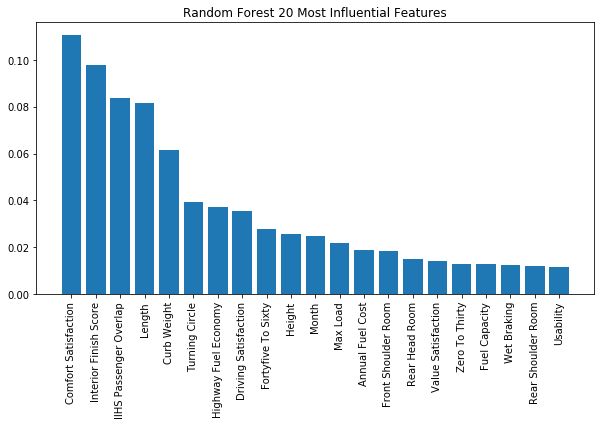

In [1146]:
box_x = list(best_estimators_df.T.sort_values(by = 0, ascending=False).index[0:21])
box_y = []
for item in list(best_estimators_df.T.sort_values(by = 0, ascending=False).values[0:21]):
    box_y.append(item[0])
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x=box_x, height=box_y)
ax.set_xticklabels(box_x, rotation='vertical')
ax.set_title('Random Forest 20 Most Influential Features')

Create Support Vector Regression GridsearchCV and fit model

In [1142]:
svr_dict = {'C': [50000, 75000, 100000],
           'epsilon': [600, 700, 800, 900, 1000]}
svr = SVR()
grid_svr=GridSearchCV(svr, svr_dict, cv=5, scoring='neg_mean_squared_error', verbose=4,n_jobs=-1)

grid_svr.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 12.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [50000, 75000, 100000],
                         'epsilon': [600, 700, 800, 900, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=4)

Calculate evaluation metrics for Support Vector Regression GridsearchCV

In [1143]:
y_train_pred_gsvr = grid_svr.best_estimator_.predict(x_train)
y_pred_gsvr = grid_svr.best_estimator_.predict(x_test)
print(grid_svr.best_score_)
print(grid_svr.best_params_)
print(grid_svr.best_estimator_)
print(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred_gsvr)))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred_gsvr)))
print(metrics.r2_score(y_train,y_train_pred_gsvr))
print(metrics.r2_score(y_test,y_pred_gsvr))
print(metrics.mean_absolute_error(y_train,y_train_pred_gsvr))
print((metrics.mean_absolute_error(y_test,y_pred_gsvr)))

-6905863.742574975
{'C': 50000, 'epsilon': 700}
SVR(C=50000, cache_size=200, coef0=0.0, degree=3, epsilon=700, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
2380.2024009320835
2897.388698067035
0.8744222679834277
0.8089214602059238
1246.425965281626
1534.453259922303
